# Image Retrieval 

## Importing Packages

In [1]:
import time
import copy
import glob
import pickle
from barbar import Bar
import numpy as np 
import pandas as pd 
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
%matplotlib inline

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torchsummary
from torchsummary import summary
from torch.optim import lr_scheduler

from tqdm import tqdm
from pathlib import Path
import gc
RANDOMSTATE = 42
import os

/Users/chiragmandal/miniconda3/envs/image_retrieval/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Setting GPU as the device

In [2]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [3]:
device = torch.device("mps")

In [4]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device("mps" if torch.cuda.is_available() else 'cpu')
print(device)

mps


   ## Dataset preprocessing

In [5]:
# preparing intermediate DataFrame
datasetPath = Path('/Users/chiragmandal/D_drive_backup/DKE_Course/personal_projects/image_retrieval/dataset')
df = pd.DataFrame()

df['image'] = [f for f in glob.glob(str(datasetPath) + "/*.jpg") if os.path.isfile(os.path.join(datasetPath, f))]
df['image'] = df['image'].astype(str)

df.head()

,image
0,/Users/chiragmandal/D_drive_backup/DKE_Course/...
1,/Users/chiragmandal/D_drive_backup/DKE_Course/...
2,/Users/chiragmandal/D_drive_backup/DKE_Course/...
3,/Users/chiragmandal/D_drive_backup/DKE_Course/...
4,/Users/chiragmandal/D_drive_backup/DKE_Course/...


In [6]:
class CBIRDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        self.transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((512,512)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        row = self.dataFrame.iloc[key]
        image = self.transformations(Image.open(row['image']))
        return image
    
    def __len__(self):
        return len(self.dataFrame.index)

## Train-Test Split

In [7]:
def prepare_data(DF):
    trainDF, testDF = train_test_split(DF, test_size=0.2, random_state=RANDOMSTATE)
    trainDF, validateDF = train_test_split(trainDF, test_size=0.3, random_state=RANDOMSTATE)
    train_set = CBIRDataset(trainDF)
    validate_set = CBIRDataset(validateDF)
    test_set = testDF
    
    return train_set, validate_set, test_set

## Model definition

In [8]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(# in- (N,3,512,512)
            
            nn.Conv2d(in_channels=3, 
                      out_channels=16, 
                      kernel_size=(3,3), 
                      stride=3, 
                      padding=1),  # (32,16,171,171)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # (N,16,85,85)
            
            nn.Conv2d(in_channels=16, 
                      out_channels=8, 
                      kernel_size=(3,3), 
                      stride=2, 
                      padding=1),  # (N,8,43,43)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # (N,8,42,42)
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels = 8, 
                               out_channels=16, 
                               kernel_size=(3,3), 
                               stride=2),  # (N,16,85,85)
            nn.ReLU(True),
 
            nn.ConvTranspose2d(in_channels=16, 
                               out_channels=8, 
                               kernel_size=(5,5), 
                               stride=3, 
                               padding=1),  # (N,8,255,255)
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=8, 
                               out_channels=3, 
                               kernel_size=(6,6), 
                               stride=2, 
                               padding=1),  # (N,3,512,512)
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
class ConvAutoencoder_v2(nn.Module):
    def __init__(self):
        super(ConvAutoencoder_v2, self).__init__()
        self.encoder = nn.Sequential(# in- (N,3,512,512)
            
            nn.Conv2d(in_channels=3, 
                      out_channels=64, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, 
                      out_channels=64, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), 
            
            nn.Conv2d(in_channels=64, 
                      out_channels=128, 
                      kernel_size=(3,3), 
                      stride=2, 
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, 
                      out_channels=128, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=0), 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), 
            
            nn.Conv2d(in_channels=128, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=2, 
                      padding=1), 
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1), 
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1), 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2) 
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels = 256, 
                               out_channels=256, 
                               kernel_size=(3,3), 
                               stride=1,
                              padding=1), 
 
            nn.ConvTranspose2d(in_channels=256, 
                               out_channels=256, 
                               kernel_size=(3,3), 
                               stride=1, 
                               padding=1),  
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=256, 
                               out_channels=128, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=0),  
            
            nn.ConvTranspose2d(in_channels=128, 
                               out_channels=64, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1),  
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=32, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1), 
            
            nn.ConvTranspose2d(in_channels=32, 
                               out_channels=32, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1),  
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=32, 
                               out_channels=3, 
                               kernel_size=(4,4), 
                               stride=2, 
                               padding=2),  
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
#summary(ConvAutoencoder_v2().to(device),(3,512,512))
summary(ConvAutoencoder_v2(),(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 126, 126]         147,584
              ReLU-9        [-1, 128, 126, 126]               0
        MaxPool2d-10          [-1, 128, 63, 63]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

## Model Training and Saving Checkpoints

In [11]:
def load_ckpt(checkpoint_fpath, model, optimizer):
    
    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['model_state_dict'])

    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']

    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch']

def save_checkpoint(state, filename):
    """Save checkpoint if a new best is achieved"""
    print ("=> Saving a new best")
    torch.save(state, filename)  # save checkpoint
    
def train_model(model,  
                criterion, 
                optimizer, 
                scheduler, 
                num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for idx,inputs in enumerate(Bar(dataloaders[phase])):
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(state={   
                                    'epoch': epoch,
                                    'state_dict': model.state_dict(),
                                    'best_loss': best_loss,
                                    'optimizer_state_dict':optimizer.state_dict()
                                },filename='/ckpt/ckpt_epoch_{}.pt'.format(epoch))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, optimizer, epoch_loss

## Training parameters

In [12]:
EPOCHS = 50
NUM_BATCHES = 16
RETRAIN = False

train_set, validate_set, test_df = prepare_data(DF=df)

dataloaders = {'train': DataLoader(train_set, batch_size=NUM_BATCHES, shuffle=True, num_workers=0) ,
                'val':DataLoader(validate_set, batch_size=NUM_BATCHES, num_workers=0)
                }

dataset_sizes = {'train': len(train_set),'val':len(validate_set)}

model = ConvAutoencoder_v2().to(device)

criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
# If re-training is required:
# Load the old model
if RETRAIN == True:
    # load the saved checkpoint
    model, optimizer, start_epoch = load_ckpt('../input/cbirpretrained/conv_autoencoder.pt', model, optimizer)
    print('Checkpoint Loaded')

In [14]:
model, optimizer, loss = train_model(model=model, 
                    criterion=criterion, 
                    optimizer=optimizer, 
                    scheduler=exp_lr_scheduler,
                    num_epochs=EPOCHS)

Epoch 0/50
----------
2653/2653: [===============================>] - ETA 1.9sss
train Loss: 0.1254
1137/1137: [===============================>] - ETA 0.8ss
val Loss: 0.0678
=> Saving a new best

Epoch 1/50
----------
2653/2653: [===============================>] - ETA 2.6sss
train Loss: 0.0623
1137/1137: [===============================>] - ETA 1.1ss
val Loss: 0.0553
=> Saving a new best

Epoch 2/50
----------
2653/2653: [===============================>] - ETA 2.5sss
train Loss: 0.0518
1137/1137: [===============================>] - ETA 1.6sss
val Loss: 0.0444
=> Saving a new best

Epoch 3/50
----------
2653/2653: [===============================>] - ETA 4.4sss
train Loss: 0.0425
1137/1137: [===============================>] - ETA 1.4sss
val Loss: 0.0398
=> Saving a new best

Epoch 4/50
----------
2653/2653: [===============================>] - ETA 4.2sss
train Loss: 0.0391
1137/1137: [===============================>] - ETA 1.4ss
val Loss: 0.0366
=> Saving a new best

Epoch 5/50
--

In [15]:
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'conv_autoencoderv2_200ep.pt')

In [16]:
transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

## Model evaluation

In [17]:
# Load Model in Evaluation phase
model = ConvAutoencoder_v2().to(device)
model.load_state_dict(torch.load('/Users/chiragmandal/D_drive_backup/DKE_Course/personal_projects/image_retrieval/conv_autoencoderv2_200ep.pt', map_location=device)['model_state_dict'], strict=False)

model.eval()

ConvAutoencoder_v2(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

## Indexing

In [18]:
import torchvision.transforms as T
transform = T.Resize((512,512))
def get_latent_features(images, transformations):
    
    latent_features = np.zeros((4738,256,16,16))
    #latent_features = np.zeros((4738,8,42,42))
    
    for i,image in enumerate(tqdm(images)):
        tensor = transformations(Image.open(image)).to(device)
        tensor = transform(tensor)
        latent_features[i] = model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy()
        
    del tensor
    gc.collect()
    return latent_features

In [28]:
images = df.image.values
latent_features = get_latent_features(images, transformations)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4738/4738 [01:20<00:00, 58.59it/s]


In [29]:
indexes = list(range(0, 4738))
feature_dict = dict(zip(indexes,latent_features))
index_dict = {'indexes':indexes,'features':latent_features}

## Image Retrieval by Euclidean Search

In [30]:
def euclidean(a, b):
    # compute and return the euclidean distance between two vectors
    return np.linalg.norm(a - b)

In [31]:
def cosine_distance(a,b):
    return scipy.spatial.distance.cosine(a, b)

In [32]:
def perform_search(queryFeatures, index, maxResults=64):

    results = []

    for i in range(0, len(index["features"])):
        # compute the euclidean distance between our query features
        # and the features for the current image in our index, then
        # update our results list with a 2-tuple consisting of the
        # computed distance and the index of the image
        d = euclidean(queryFeatures, index["features"][i])
        results.append((d, i))
    
    # sort the results and grab the top ones
    results = sorted(results)[:maxResults]
    # return the list of results
    return results

In [33]:
def build_montages(image_list, image_shape, montage_shape):

    if len(image_shape) != 2:
        raise Exception('image shape must be list or tuple of length 2 (rows, cols)')
    if len(montage_shape) != 2:
        raise Exception('montage shape must be list or tuple of length 2 (rows, cols)')
    image_montages = []
    # start with black canvas to draw images onto
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        start_new_img = False
        img = cv2.resize(img, image_shape)
        # draw image to black canvas
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # reset black canvas
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_montages.append(montage_image)  # add unfinished montage
    return image_montages

5
3466
4438
466
902
3157
591
1543
4263
2844
3670
480


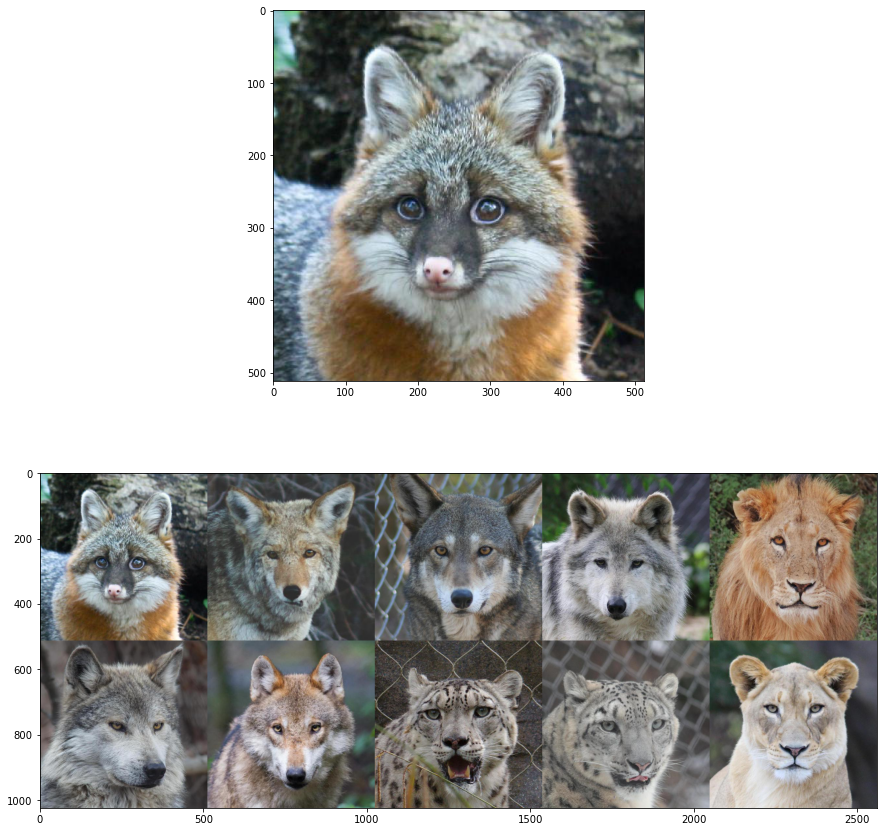

In [34]:
# take the features for the current image, find all similar
# images in our dataset, and then initialize our list of result
# images
fig, ax = plt.subplots(nrows=2,figsize=(15,15))
queryIdx = 5# Input Index for which images 
MAX_RESULTS = 12


queryFeatures = latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)
imgs = []

corrects = []
# loop over the results
for (d, j) in results:
    img = np.array(Image.open(images[j]))
    print(j)
    imgs.append(img)

# display the query image
ax[0].imshow(np.array(Image.open(images[queryIdx])))

# build a montage from the results and display it
montage = build_montages(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)

In [35]:
testimages = test_df['image'].values

In [36]:
test_latent_features = get_latent_features(testimages, transformations)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:17<00:00, 55.66it/s]


In [37]:
test_latent_features.shape

(4738, 256, 16, 16)

3935
2497
307
4326
1275
1177
2343
103
582
3683


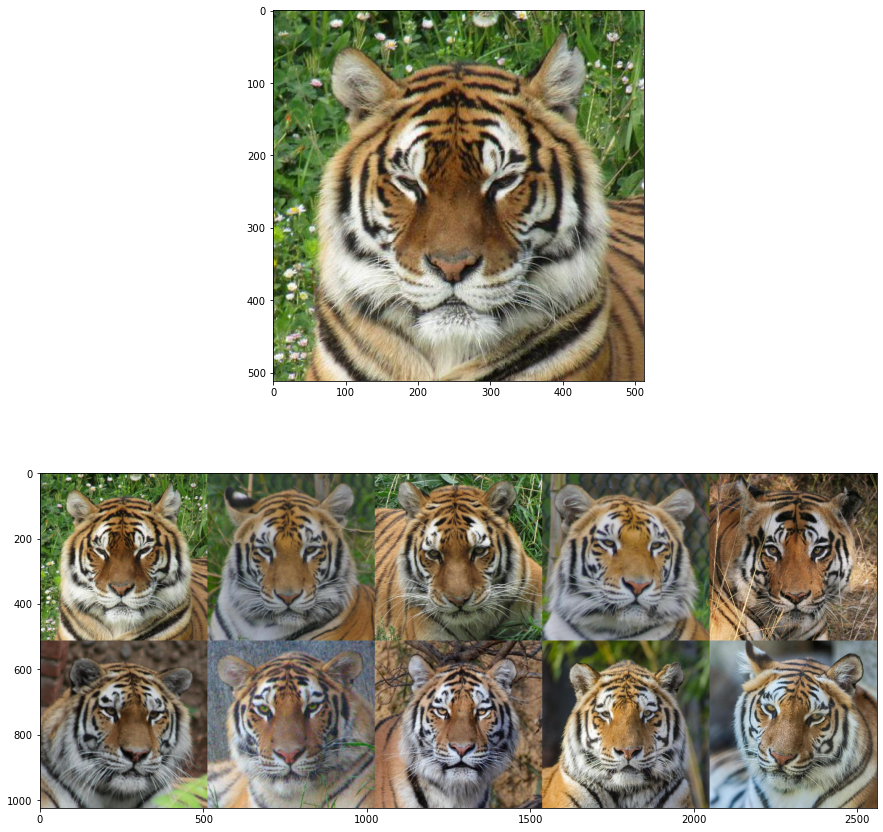

In [38]:
fig, ax = plt.subplots(nrows=2,figsize=(15,15))
MAX_RESULTS = 10
queryIdx = 4

queryFeatures = test_latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)
imgs = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(images[j]))
    print(j)
    imgs.append(img)

# display the query image
ax[0].imshow(np.array(Image.open(testimages[queryIdx])))

# build a montage from the results and display it
montage = build_montages(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)